In [1]:
import os

os.environ["LD_LIBRARY_PATH"] = ":/home/ztan/.mujoco/mujoco200/bin"
os.environ.get("LD_LIBRARY_PATH", "")
from gym.envs.mujoco import HalfCheetahEnv
from gym.envs.box2d import CarRacing

import rlkit.torch.pytorch_util as ptu
from rlkit.data_management.env_replay_buffer import EnvReplayBuffer
from rlkit.envs.wrappers import NormalizedBoxEnv
from rlkit.launchers.launcher_util import setup_logger
from rlkit.samplers.data_collector import MdpPathCollector
from rlkit.torch.sac.policies import (
    TanhGaussianPolicy,
    MakeDeterministic,
    TanhCNNGaussianPolicy,
    GaussianCNNPolicy,
)
from rlkit.torch.sac.sac import SACTrainer
from rlkit.torch.networks import ConcatMlp, PretrainedCNN, CNN
from rlkit.torch.torch_rl_algorithm import TorchBatchRLAlgorithm

import torch
import torchvision.models as models

from absl import app, flags
from typing import Sequence
import sys
from absl import app
from dm_control import viewer
from dm_robotics.moma import action_spaces


import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

import dmc2gym
from gym import core, spaces
from dm_control import suite
from dm_env import specs
import numpy as np
from rgb_stacking import environment

No personal conf_private.py found.
doodad not detected


In [2]:
# action = action = np.array([0, 0, 0, 0, 0], dtype=np.float32)
# env = environment.rgb_stacking(observation_set=environment.ObservationSet.VISION_ONLY, object_triplet='rgb_test_triplet1')
# env.reset()
# out = env.step(action)
# # ptu.set_gpu_mode(True)


In [3]:
# from dm_env import specs
# def _spec_to_box(spec):
#     def extract_min_max(s):
#         # assert s.dtype == np.float64 or s.dtype == np.float32
#         dim = np.int(np.prod(s.shape))
#         if type(s) == specs.Array:
#             bound = np.inf * np.ones(dim, dtype=np.float32)
#             return -bound, bound
#         elif type(s) == specs.BoundedArray:
#             zeros = np.zeros(dim, dtype=np.float32)
#             return s.minimum + zeros, s.maximum + zeros

#     mins, maxs = [], []
#     for s in spec:
#         mn, mx = extract_min_max(s)
#         mins.append(mn)
#         maxs.append(mx)
#     low = np.concatenate(mins, axis=0)
#     high = np.concatenate(maxs, axis=0)
#     assert low.shape == high.shape
#     return spaces.Box(low, high, dtype=np.float32)
# expl_env = NormalizedBoxEnv(CarRacing())
# obs_dim = expl_env.observation_space.low.size
# action_dim = expl_env.action_space.low.size
# obs_dim, action_dim # yes we flatten anyways
# action = action = np.array([0, 0, 0, 0, 0], dtype=np.float32)



In [4]:
action = action = np.array([0, 0, 0, 0, 0], dtype=np.float32)
env = dmc2gym.make(domain_name="rgb_stacking", task_name='rgb_test_triplet1')
o = env.reset()
out = env.step(action)
env.observation_space.shape

self._using_rgb_stacking True


Failed to establish dbus connection

(256, 128, 3)

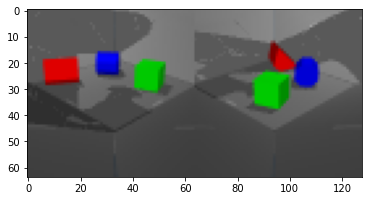

In [26]:
import cv2
img = out[0].reshape(128,256,3)
%matplotlib inline 
from matplotlib import pyplot as plt
# plt.imshow(img)
plt.imshow(cv2.resize(img, dsize=(128, 64)))
plt.show()

In [ ]:
raise ValueError

In [16]:
1235496 * 32 /(8e6)

4.941984

In [17]:
from torchinfo import summary
summary(models.efficientnet_b0())


Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─ConvNormActivation: 2-1                          --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

In [13]:
for i in dir(models):
    print(i)

AlexNet
DenseNet
EfficientNet
GoogLeNet
GoogLeNetOutputs
Inception3
InceptionOutputs
MNASNet
MobileNetV2
MobileNetV3
RegNet
ResNet
ShuffleNetV2
SqueezeNet
VGG
_GoogLeNetOutputs
_InceptionOutputs
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
_utils
alexnet
densenet
densenet121
densenet161
densenet169
densenet201
detection
efficientnet
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
feature_extraction
googlenet
inception
inception_v3
mnasnet
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mobilenetv2
mobilenetv3
quantization
regnet
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext5

# fk u

In [ ]:
variant = dict(
    algorithm="SAC",
    version="normal",
    layer_size=256,
    replay_buffer_size=int(2e4),
    algorithm_kwargs=dict(
        num_epochs=300,
        num_eval_steps_per_epoch=500,
        num_trains_per_train_loop=100,
        num_expl_steps_per_train_loop=100,
        min_num_steps_before_training=100,
        max_path_length=1000,
        batch_size=16,
    ),
    trainer_kwargs=dict(
        discount=0.99,
        soft_target_tau=5e-3,
        target_update_period=1,
        policy_lr=3e-4,
        qf_lr=3e-4,
        reward_scale=1,
        use_automatic_entropy_tuning=True,
    ),
)



In [ ]:
expl_env = NormalizedBoxEnv(CarRacing())
eval_env = NormalizedBoxEnv(CarRacing())
obs_dim = expl_env.observation_space.low.size
action_dim = eval_env.action_space.low.size
M = variant["layer_size"]


In [ ]:
# "size" will return the desired product of dimensions

(
    input_width,
    input_height,
    input_channels,
) = expl_env.observation_space.shape  # channel last!!!
qf1 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
qf2 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
target_qf1 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
target_qf2 = PretrainedCNN(
    input_width,
    input_height,
    input_channels,
    output_size=1,
    hidden_sizes=[128, 64],  # this is the hidden sizes of FC layers after the CNN
    added_fc_input_size=action_dim,  # layer used to merge image output and action input
    batch_norm_fc=False,
    init_w=1e-4,
    # hidden_init=nn.init.xavier_uniform_,
    # hidden_activation=nn.ReLU(),
    # output_activation=identity,
    output_conv_channels=False,
    model_architecture=models.efficientnet_b0,
    model_pretrained=True,
    model_freeze=False,
)
policy = GaussianCNNPolicy(
    hidden_sizes=[128, 64],  # hidden size of FC after CNN; it uses "return_last_activations" to skip the last FC
    obs_dim=obs_dim,
    action_dim=action_dim,
    std=None,
    init_w=1e-3,
    min_log_std=-20,
    max_log_std=2,
    std_architecture="shared",
    **{
        "input_width": input_width,
        "input_height": input_height,
        "input_channels": input_channels,
        "kernel_sizes": [5, 5, 5],
        "n_channels": [32, 64, 128],
        "strides": [1] * 3,
        "paddings": ["same"] * 3,
    },
)

# self.conv_output_flat_size: 1280 is the CNN output (effnet for example!)


In [ ]:
eval_policy = MakeDeterministic(policy)
eval_path_collector = MdpPathCollector(eval_env, eval_policy,)
expl_path_collector = MdpPathCollector(expl_env, policy,)
replay_buffer = EnvReplayBuffer(variant["replay_buffer_size"], expl_env,)

trainer = SACTrainer(
        env=eval_env,
        policy=policy,
        qf1=qf1,
        qf2=qf2,
        target_qf1=target_qf1,
        target_qf2=target_qf2,
        **variant["trainer_kwargs"]
    )
algorithm = TorchBatchRLAlgorithm(
    trainer=trainer,
    exploration_env=expl_env,
    evaluation_env=eval_env,
    exploration_data_collector=expl_path_collector,
    evaluation_data_collector=eval_path_collector,
    replay_buffer=replay_buffer,
    **variant["algorithm_kwargs"]
)

In [ ]:
setup_logger("carRace_testing", variant=variant)
algorithm.to(ptu.device)
algorithm.train()

In [ ]:
raise ValueError

In [ ]:
import numpy as np
trial = (np.random.randn(1,96,96,3), np.random.randn(1,3))
torch.from_numpy(*trial)

In [ ]:
from gym.envs.mujoco import HalfCheetahEnv
from gym.envs.box2d import CarRacing

import rlkit.torch.pytorch_util as ptu
from rlkit.data_management.env_replay_buffer import EnvReplayBuffer
from rlkit.envs.wrappers import NormalizedBoxEnv
from rlkit.launchers.launcher_util import setup_logger
from rlkit.samplers.data_collector import MdpPathCollector
from rlkit.torch.sac.policies import (
    TanhGaussianPolicy,
    MakeDeterministic,
    TanhCNNGaussianPolicy,
    GaussianCNNPolicy,
)
from rlkit.torch.sac.sac import SACTrainer
from rlkit.torch.networks import ConcatMlp, PretrainedCNN, CNN
from rlkit.torch.torch_rl_algorithm import TorchBatchRLAlgorithm

import torch
import torchvision.models as models

ptu.set_gpu_mode(True)

def experiment(variant):
    expl_env = NormalizedBoxEnv(HalfCheetahEnv())
    eval_env = NormalizedBoxEnv(HalfCheetahEnv())
    obs_dim = expl_env.observation_space.low.size
    action_dim = eval_env.action_space.low.size

    M = variant["layer_size"]
    qf1 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    qf2 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    target_qf1 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    target_qf2 = ConcatMlp(
        input_size=obs_dim + action_dim, output_size=1, hidden_sizes=[M, M],
    )
    policy = TanhGaussianPolicy(
        obs_dim=obs_dim, action_dim=action_dim, hidden_sizes=[M, M],
    )
    eval_policy = MakeDeterministic(policy)
    eval_path_collector = MdpPathCollector(eval_env, eval_policy,)
    expl_path_collector = MdpPathCollector(expl_env, policy,)
    replay_buffer = EnvReplayBuffer(variant["replay_buffer_size"], expl_env,)
    trainer = SACTrainer(
        env=eval_env,
        policy=policy,
        qf1=qf1,
        qf2=qf2,
        target_qf1=target_qf1,
        target_qf2=target_qf2,
        **variant["trainer_kwargs"]
    )
    algorithm = TorchBatchRLAlgorithm(
        trainer=trainer,
        exploration_env=expl_env,
        evaluation_env=eval_env,
        exploration_data_collector=expl_path_collector,
        evaluation_data_collector=eval_path_collector,
        replay_buffer=replay_buffer,
        **variant["algorithm_kwargs"]
    )
    algorithm.to(ptu.device)
    algorithm.train()

if __name__ == "__main__":
    # noinspection PyTypeChecker
    variant = dict(
        algorithm="SAC",
        version="normal",
        layer_size=256,
        replay_buffer_size=int(2e4),
        algorithm_kwargs=dict(
            num_epochs=1,
            num_eval_steps_per_epoch=500,
            num_trains_per_train_loop=100,
            num_expl_steps_per_train_loop=100,
            min_num_steps_before_training=100,
            max_path_length=1000,
            batch_size=16,
        ),
        trainer_kwargs=dict(
            discount=0.99,
            soft_target_tau=5e-3,
            target_update_period=1,
            policy_lr=3e-4,
            qf_lr=3e-4,
            reward_scale=1,
            use_automatic_entropy_tuning=True,
        ),
    )
    setup_logger("name-of-experiment", variant=variant)
    ptu.set_gpu_mode(True)  # optionally set the GPU (default=False)
    experiment(variant)



In [ ]:
expl_env = NormalizedBoxEnv(HalfCheetahEnv())
eval_env = NormalizedBoxEnv(HalfCheetahEnv())

In [ ]:
expl_env.observation_space

In [ ]:
expl_env.observation_space.low.size